In [47]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import qutip
import scqubits
from IPython.display import clear_output

import sys
sys.path.append('../')
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
from CoupledQuantumSystems.drive import DriveTerm,square_pulse_with_rise_fall
from CoupledQuantumSystems.evo_parrallel import run_parallel_ODEsolve_and_post_process_jobs_with_different_systems

In [2]:
max_ql = 30
max_ol = 100
EJ = 3
EC = EJ/4
EL = EJ/20.5
Er = 8.46111172

g = 0.2
system  =  FluxoniumOscillatorSystem(
                EJ = EJ,
                EC = EC,
                EL = EL,
                Er = Er,
                g_strength = g,
                qubit_level = max_ql,
                osc_level = max_ol,
                products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol) ],
                computaional_states = '1,2',
                )
 

In [203]:
import time

def find_dressed_idx_of_qubit_i_resonator_n_plus_one(dressed_idx_of_qubit_i_resonator_n:int,
                                                     dressed_creation_arr:qutip.qobj,
                                                     eigenvec_arr:np.array,
                                                     evals:np.ndarray,
                                                     bare_resonator_frequency: float):
    # A heuristic is that the target dressed state has eigenenergy close to the original + bare resonator frequency
    
    last_state = eigenvec_arr[dressed_idx_of_qubit_i_resonator_n]
    last_state_after_adagger = dressed_creation_arr @last_state
    denominator = np.vdot(last_state_after_adagger, last_state_after_adagger)
    rough_eval = evals[dressed_idx_of_qubit_i_resonator_n]+bare_resonator_frequency

    overlap_list = []
    diff_arr = np.abs(evals - rough_eval)
    # closest_indices = np.argpartition(diff_arr, 80)[:80]
    close_indices = np.where(np.abs(diff_arr) < 10)[0]
    for idx in close_indices:
        overlap =( np.vdot(eigenvec_arr[idx], last_state_after_adagger) /denominator)**2
        overlap_list.append(overlap)
    # print(closest_indices[np.argmax(overlap_list)])
    # plt.plot(closest_indices,overlap_list)
    # plt.show()
    # time.sleep(2)
    return close_indices[np.argmax(overlap_list)]

    # overlaps = np.abs(eigenvec_arr.conj().T @ last_state_after_adagger / denominator) ** 2
    # overlaps = overlaps.flatten()
    # big_overlap_indices = np.argpartition(overlaps,  -50)[-50:][::-1]
    # diff_arr = np.abs(evals[big_overlap_indices] - rough_eval)
    # for idx in range(len(big_overlap_indices)):
    #     if idx == dressed_idx_of_qubit_i_resonator_n:
    #         continue
    #     if diff_arr[idx]<bare_resonator_frequency*2:
    #         print(big_overlap_indices[idx])
    #         plt.plot(overlaps)
    #         plt.show()
    #         time.sleep(2)
    #         return big_overlap_indices[idx]
    raise Exception(f'error: big_overlap_indices:{big_overlap_indices}, diff_arr:{diff_arr}')

In [204]:
idx_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in range(max_ql):
    idx_arr[ql,0] = system.product_to_dressed[(ql,0)]
    for ol in range(1,max_ol):
        next_idx = find_dressed_idx_of_qubit_i_resonator_n_plus_one(
            dressed_idx_of_qubit_i_resonator_n = idx_arr[ql,ol-1],
            dressed_creation_arr = system.a.full(),
            eigenvec_arr = system.eigenvec_arr,
            evals = system.evals,
            bare_resonator_frequency = Er)
        idx_arr[ql,ol] = next_idx
        clear_output()
        print(f"ql:{ql},ol:{ol}")
    #     plt.plot(overlap_list)
    #     break
    # break

ql:29,ol:99


In [ ]:
plt.imshow(idx_arr)

# problem: may assign repeatedly.

In [190]:
flattened = idx_arr.flatten()

# Get unique elements and their counts
unique_elements, counts = np.unique(flattened, return_counts=True)

# Find elements that are repeated
duplicates = unique_elements[counts > 1]

In [191]:
duplicates

array([  55,   80,  102,  110,  115,  123,  131,  138,  140,  150,  162,
        164,  172,  178,  187,  195,  198,  200,  210,  222,  227,  230,
        234,  238,  247,  255,  258,  260,  270,  282,  284,  287,  288,
        290,  294,  295,  296,  305,  312,  314,  316,  319,  327,  328,
        345,  353,  356,  358,  374,  377,  382,  394,  406,  411,  418,
        419,  435,  437,  444,  446,  467,  475,  478,  483,  495,  497,
        504,  510,  527,  535,  538,  543,  555,  559,  562,  568,  577,
        587,  588,  602,  604,  614,  617,  619,  622,  625,  639,  653,
        667,  674,  682,  695,  701,  706,  727,  731,  743,  760,  761,
        767,  789,  791,  806,  820,  824,  825,  836,  849,  851,  855,
        858,  870,  879,  881,  884,  885,  906,  910,  912,  919,  939,
        945,  968,  971,  972,  979, 1000, 1015, 1024, 1031, 1038, 1055,
       1071, 1087, 1089, 1098, 1115, 1130, 1147, 1149, 1162, 1177, 1190,
       1194, 1205, 1216, 1227, 1233, 1237, 1250, 12

(0.0, 50.0)

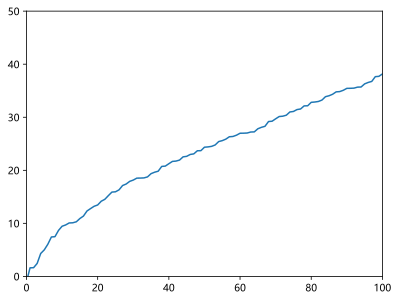

In [196]:
# plt.figure(figsize=(10,10))
plt.plot(system.evals)
plt.xlim(0,100)
plt.ylim(0,50)

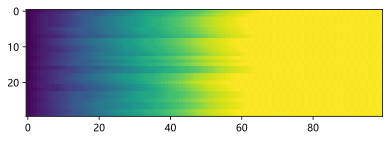

In [186]:
plt.imshow(idx_arr)

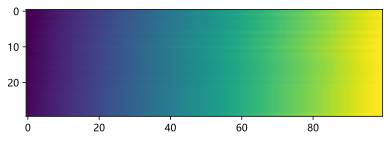

In [53]:
plt.imshow(idx_arr)

# How to get the average fluxonium population? By basis changing into product state?

looping:   0%|          | 0/30 [00:00<?, ?it/s]ComplexWarning: Casting complex values to real discards the imaginary part
 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/cbook.py: 1699ComplexWarning: Casting complex values to real discards the imaginary part
looping: 100%|██████████| 30/30 [02:53<00:00,  5.78s/it]ages/matplotlib/cbook.py: 1345


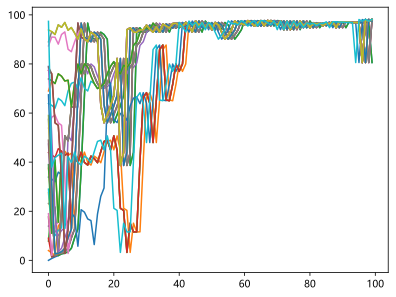

In [56]:
photon_num_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in tqdm(range(max_ql),'looping'):
    dressed_idx_arr = idx_arr[ql]
    for ol in range(max_ol):
        state_after_a = system.a.full() @ system.evecs[idx_arr[ql,ol]].full()
        photon_num_arr[ql,ol] = np.vdot(state_after_a,state_after_a)

    # Extract the relevant evecs for current ql
    evecs_for_ql = system_evecs_full[ql, idx_arr[ql]]
    
    # Compute the state after applying 'a'
    state_after_a = np.dot(system_a_full, evecs_for_ql)

    # Compute photon number using dot products
    photon_num_arr[ql] = np.einsum('ij,ij->j', state_after_a, state_after_a.conj())

In [71]:
system.eigenvec_arr = np.array([system.evecs[idx].full() for idx in range(system.hilbertspace.dimension)])

In [73]:
system.eigenvec_arr[3]

array([[ 0.        +0.j],
       [-0.01436142+0.j],
       [ 0.        +0.j],
       ...,
       [ 0.        +0.j],
       [ 0.        +0.j],
       [ 0.        +0.j]])